# Project Background

Marketing companies want to run successful campaigns, but the market is complex and several options can work. So normally they tun A/B tests, that is a randomized experimentation process where two or more versions of a variable (web page, page element, banner, etc.) are shown to different segments of people at the same time to determine which version leaves the maximum impact and drive business metrics. 

In this project, we are helping a company to measure the effectiveness of its ad campaign. 
The business metric in our case is conversion rate which is the ratio of the number of purchases to the total number of ad displays .

# A/B Testing Process

We follow the guidance of this Kaggle notebook (https://www.kaggle.com/code/ekrembayar/a-b-testing-step-by-step-hypothesis-testing) to conduct our A/B testing.

1) Understanding business problem & data

2) Detect and resolve problems in the data (Missing Value, Outliers, Unexpected Value)

3) Look summary stats and plots

4) Apply hypothesis testing and check assumptions

5) Check Normality & Homogeneity

6) Apply tests ( T-Test)

7) Evaluate the results

8) Make inferences

9) Recommend business decision to your customer/director/ceo etc.

# 1) Business Problem & Experiment Design

We defined our business problems as:

1) Did the campaign have a positive impact on user's conversion? 

2) Would users be more likely to convert if more ads are displayed to them? 

We randomly assigned our users to the treatment group where the users will be exposed to ads and control group where the users will instead see a Public Service Announcement (or nothing). The majority of the people will be exposed to ads. And a small portion of people (the control group) would instead see a Public Service Announcement (or nothing) in the exact size and place the ad would normally be.

# 2) Data Description

Our dataset is from https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing, which has 588,101 records and 7 columns. The variables are: 

- user id: User ID (unique)
- test group: If "ad" the person saw the advertisement, if "psa" they only saw the public service announcement
- converted: If a person bought the product then True, else is False
- total ads: Amount of ads seen by person
- most ads day: Day that the person saw the biggest amount of ads
- most ads hour: Hour of day that the person saw the biggest amount of ads

In [18]:
import pandas as pd
import io
import numpy as np

In [19]:
# Build load function to load the data and print data description
def load(path, info = True):
    read = pd.read_csv(path)
    
    if info:
        if len(read) > 0:
            print("# Data imported!")
            print("# ------------------------------------", "\n")
        
            print("# DIMENSIONS -------------------------")
            print("Observation:", read.shape[0], "Column:", read.shape[1], "\n")
    
            print("# DTYPES -----------------------------")
            if len(read.select_dtypes("object").columns) > 0:
                print("Object Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("object").columns), "\n", 
                      read.select_dtypes("object").columns.tolist(), "\n")
            if len(read.select_dtypes("integer").columns) > 0:
                print("Integer Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("integer").columns), "\n", 
                      read.select_dtypes("integer").columns.tolist(), "\n")
            if len(read.select_dtypes("bool").columns) > 0:
                print("Bool Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("bool").columns), "\n", 
                      read.select_dtypes("bool").columns.tolist(), "\n")
            print("# MISSING VALUE ---------------------")
            print("Are there any missing values? \n ", np.where(read.isnull().values.any() == False, 
                                                                "No missing value!", "Data includes missing value!"), "\n")
            buf = io.StringIO()
            read.info(buf=buf)
            info = buf.getvalue().split('\n')[-2].split(":")[1].strip()
            print("# MEMORY USAGE ---------------------- \n", info)
          
        else:
            print("# Data did not import!")
    return read

    

In [30]:
ab = load("marketing_AB.csv", info = True)
ab.head()

# Data imported!
# ------------------------------------ 

# DIMENSIONS -------------------------
Observation: 588101 Column: 7 

# DTYPES -----------------------------
Object Variables: 
 # of Variables: 2 
 ['test group', 'most ads day'] 

Integer Variables: 
 # of Variables: 4 
 ['Unnamed: 0', 'user id', 'total ads', 'most ads hour'] 

Bool Variables: 
 # of Variables: 1 
 ['converted'] 

# MISSING VALUE ---------------------
Are there any missing values? 
  No missing value! 

# MEMORY USAGE ---------------------- 
 27.5+ MB


,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


Insights:
- We have 3 categorical variables: test group, converted and most ads day, and 2 numeric variables: total ads and most ads hour.
- There is no missing values.
- There are 588,101 observations in our dataset.

# 3) Summary Statistics

In [4]:
# Check if the user id is unique
print(ab['user id'].nunique() == ab.shape[0])

True


In [5]:
# Summary Stats: total ads
ab.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["total ads"]].T


,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
total ads,588101.0,24.820876,43.715181,1.0,1.0,1.0,2.0,3.0,13.0,33.0,57.0,88.0,202.0,2065.0


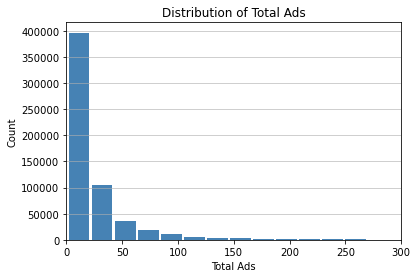

In [69]:
# Distribution of Total Ads
import matplotlib.pyplot as plt
ab['total ads'].plot.hist( rwidth=0.9,color='steelblue',bins= 100)
plt.title('Distribution of Total Ads')
plt.xlabel('Total Ads')
plt.ylabel('Count')
plt.xlim([0, 300])
plt.grid(axis='y', alpha=0.75)

Insights:

- Total Ads is right skewed
- Most users were shown 0 - 50 ads
- The maximum total ads is 2065. It is an outlier.

In [7]:
# Summary Stats: most ads hour
ab.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["most ads hour"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
most ads hour,588101.0,14.469061,4.834634,0.0,1.0,8.0,9.0,11.0,14.0,19.0,21.0,22.0,23.0,23.0


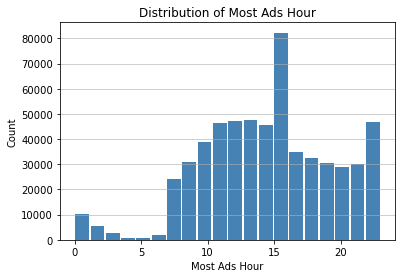

In [65]:
# Distribution of most ads hour
import matplotlib.pyplot as plt

ab['most ads hour'].plot.hist(bins=20, rwidth=0.9,
                   color='steelblue')
plt.title('Distribution of Most Ads Hour')
plt.xlabel('Most Ads Hour')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)

Insights:

- Users are shown the ads mostly between 8 am - 5 pm

In [9]:
# Summary Stats: most ads day
ab['most ads day'].value_counts()

Friday       92608
Monday       87073
Sunday       85391
Thursday     82982
Saturday     81660
Wednesday    80908
Tuesday      77479
Name: most ads day, dtype: int64

Insights:
- Ads are displayed the most on Fridays.

In [10]:
# Treatment & Control Groups Summary Stats - Total Ads
ab[['total ads','test group']].groupby("test group").agg(["count", "median", "mean", "std", "max"])

total ads                                   
               count median       mean        std   max
test group                                             
ad            564577     13  24.823365  43.750456  2065
psa            23524     12  24.761138  42.860720   907

Insights:
- No major difference in mean and std of total ads between treatment and control groups
- The outlier in treatment group is more extreme than the one in the control group

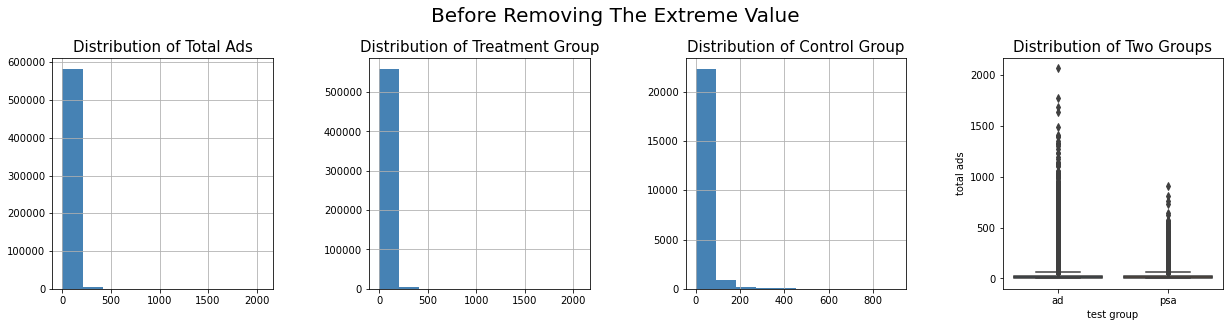

In [46]:
import seaborn as sns
fig, axes = plt.subplots(1, 4, figsize = (18,5))
ab["total ads"].hist(ax = axes[0], color = "steelblue")
ab[(ab["test group"]== "ad")].hist("total ads", ax = axes[1], color = "steelblue")
ab[(ab["test group"] == "psa")].hist("total ads", ax = axes[2], color = "steelblue")
sns.boxplot(x = ab["test group"], y = ab["total ads"], ax = axes[3])

plt.suptitle("Before Removing The Extreme Value", fontsize = 20)
axes[0].set_title("Distribution of Total Ads", fontsize = 15)
axes[1].set_title("Distribution of Treatment Group", fontsize = 15)
axes[2].set_title("Distribution of Control Group", fontsize = 15)
axes[3].set_title("Distribution of Two Groups", fontsize = 15)

plt.tight_layout(pad = 4);

Insights:
- Users in the treatment group see more ads than the control group. It may be due to the campaign operation. The treatment group saw more ads than the control group.

In [11]:
# Treatment & Control Groups Summary Stats
ab[['most ads hour','test group']].groupby("test group").agg(["count", "median", "mean", "std", "max"])

most ads hour                                
                   count median       mean       std max
test group                                              
ad                564577     14  14.475900  4.841808  23
psa                23524     14  14.304923  4.656239  23

Insights:
- No major difference in mean and std of most ads hour between treatment and control groups

# 4) A/B Testing

$H_0$: There is no difference in the conversion rate between two groups ($C_{treatment} = C_{control}$)

$H_1$: The conversion rate of the treatment group is greater than the control group ($C_{treatment} > C_{control}$)

We run a two-sample z-test to compare the difference between proportions, the conversion rate in our case, at a significance level of 5%. First, we need to check the assumptions of the test.

Assumptions of a two-sample z-test:

- The samples are random
- The samples are independent
- The samples are large enough to use a normal sampling distribution. $n \times p \ge 5 $ and $n \times (1-p) \ge 5$

All the conditions are satisfied. We can go ahead and run the test.

In [38]:
# Replace true with 1 and false with 0 in the converted column
mapping = {True: 1, False: 0}
ab['converted'] = ab['converted'].apply(lambda x: mapping[x])

In [39]:
ab.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,0,130,Monday,20
1,1,1119715,ad,0,93,Tuesday,22
2,2,1144181,ad,0,21,Tuesday,18
3,3,1435133,ad,0,355,Tuesday,10
4,4,1015700,ad,0,276,Friday,14


In [41]:
ab.groupby('test group')['converted'].mean()

test group
ad     0.025547
psa    0.017854
Name: converted, dtype: float64

In [54]:
convert_control = ab[(ab["converted"] == 1) & (ab["test group"] == "psa")]['user id'].nunique()
convert_treatment = ab[(ab["converted"] == 1) & (ab["test group"] == "ad")]['user id'].nunique()
n_treatment = ab[ab["test group"] == "ad"]['user id'].nunique()
n_control = ab[ab["test group"] == "psa"]['user id'].nunique()

In [56]:
import statsmodels.api as sm
#Compute test statistic and p-value
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_treatment,convert_control]),
                                              np.array([n_treatment,n_control]), alternative = 'larger')

In [57]:
z_score, p_value 

(7.3700781265454145, 8.526403580779863e-14)

# A/B Testing Conclusion

The p-value is 8.526403580779863e-14 < 0.05. Therefore, we reject null. The treatment group has a significant higher conversion rate than the control group. The ad compaign had a positive impact on the conversion rate.

# 5) Regression Analysis

Now that we know that the campaign is effective, let's go back to the the second question: would users be more likely to convert if more ads are displayed to them? To answer this question, we can run a logistic regression with the independent variable as Total Ads and the dependent variable as Converted. 

In [58]:
ab["intercept"] = 1
ab.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour,intercept
0,0,1069124,ad,0,130,Monday,20,1
1,1,1119715,ad,0,93,Tuesday,22,1
2,2,1144181,ad,0,21,Tuesday,18,1
3,3,1435133,ad,0,355,Tuesday,10,1
4,4,1015700,ad,0,276,Friday,14,1


In [71]:
ab["treatment"] = ab["test group"].apply(lambda x: 1 if (x == "ad") else 0)

In [74]:
model = sm.Logit(ab['converted'], ab[['intercept','total ads',"treatment"]])
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.108986
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               588101
Model:                          Logit   Df Residuals:                   588098
Method:                           MLE   Df Model:                            2
Date:                Wed, 29 Jun 2022   Pseudo R-squ.:                 0.07467
Time:                        16:32:01   Log-Likelihood:                -64095.
converged:                       True   LL-Null:                       -69267.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -4.4307      0.051    -86.695      0.000      -4.531      -4.330
total ads      0.0101   9.86e-05    102.886      0.000       0.010       0.010
treatment      0.3894      0.051      7.562      0.000       0.288       0.490
==============================================================================
"""

Insights:

- The coefficient of total ads is significant. The number of ads a user sees would significantly affect the conversion.
- The coefficient of total ads is 0.0101. It means the odds of purchasing will increase by exp(0.0101) - 1 = 1% for a one-unit increase in total ads displayed.

# 6) Business Recommendations

We can make the following recommendations based on our analysis:

1) Our ad compaign was successful. We can conduct more similar compaigns in the future to boost our sales.

2) The more times the user sees an ad, the more likely he/she will purchase. To determine how many times we should retarget a user to increase the conversion rate, we will need to collect the historical compaign and purchase as well as timestamp data. 